In [ ]:
!ls

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline 

In [2]:
import xgboost
import catboost
import seaborn

from sklearn import linear_model, preprocessing, model_selection

In [3]:
def rmse_cv(model, X, y):
    rmse= np.sqrt(-model_selection.cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(round(rmse.mean(), 5))

In [4]:
data_train = pd.read_csv('train.csv')
data_train = data_train.drop(data_train[(data_train['GrLivArea']>4000) & (data_train['SalePrice']<300000)].index)

data_test = pd.read_csv('test.csv')

In [5]:
display(data_train.head(5))
print('shape:', data_train.shape)
print()
data_train.info()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


shape: (1458, 81)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 81 columns):
Id               1458 non-null int64
MSSubClass       1458 non-null int64
MSZoning         1458 non-null object
LotFrontage      1199 non-null float64
LotArea          1458 non-null int64
Street           1458 non-null object
Alley            91 non-null object
LotShape         1458 non-null object
LandContour      1458 non-null object
Utilities        1458 non-null object
LotConfig        1458 non-null object
LandSlope        1458 non-null object
Neighborhood     1458 non-null object
Condition1       1458 non-null object
Condition2       1458 non-null object
BldgType         1458 non-null object
HouseStyle       1458 non-null object
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
RoofStyle        1458 non-null object
RoofMatl         1458 non-null object
Exterior

In [6]:
for index, i in enumerate(np.sum(data_train.isnull())):
    if i != 0:
        print(np.sum(data_train.isnull()).index[index], i)

LotFrontage 259
Alley 1367
MasVnrType 8
MasVnrArea 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1452
Fence 1177
MiscFeature 1404


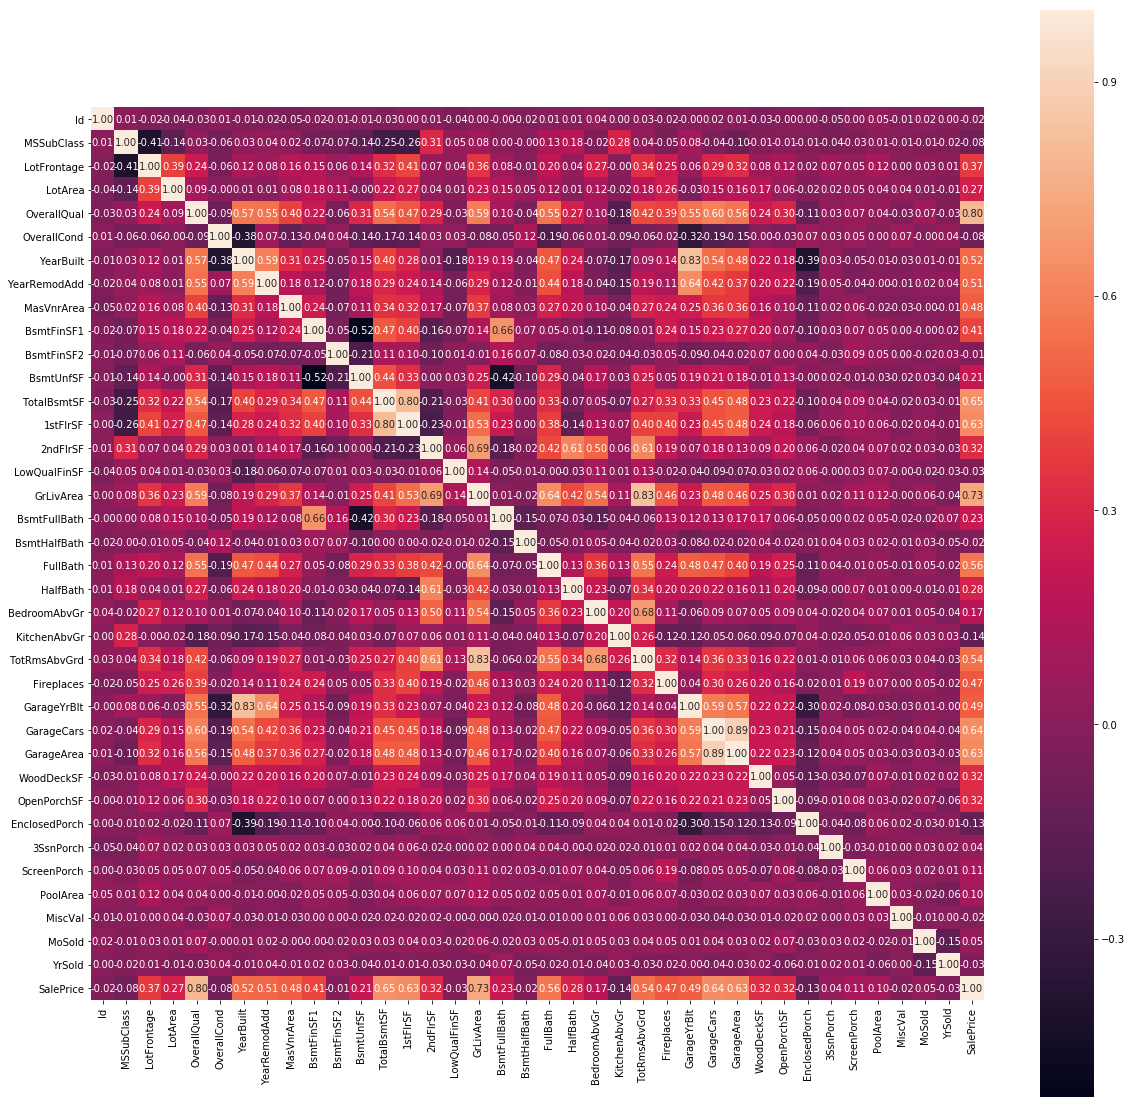

In [7]:
plt.figure(figsize=(20,20))
seaborn.heatmap(data_train.corr(), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

In [8]:
df_train_test = pd.concat((data_train.loc[:,'MSSubClass':'SaleCondition'],
                      data_test.loc[:,'MSSubClass':'SaleCondition']))

In [9]:
df_train_test['TotalSF'] = df_train_test['TotalBsmtSF'] + df_train_test['1stFlrSF'] + df_train_test['2ndFlrSF']

#price per feet engineering:
#cost of 1 square feet of living area per house by Neighborhood groups
#Its a kind of mean encoding (or likehood encoding)
data_train['DolPerFeetLiv'] = data_train['SalePrice']/data_train['GrLivArea']
data = pd.concat([data_train['Neighborhood'], data_train['DolPerFeetLiv']], axis=1)
cost_per_district = data.groupby('Neighborhood')['DolPerFeetLiv'].mean()
df_train_test['DolPerFeetNeigLiv'] = df_train_test['Neighborhood'].apply(lambda x: cost_per_district[x])

#cost of 1 square feet of lot area per house by Neighborhood groups
data_train['DolPerFeetLot'] = data_train['SalePrice']/data_train['LotArea']
data = pd.concat([data_train['Neighborhood'], data_train['DolPerFeetLot']], axis=1)
cost_per_district = data.groupby('Neighborhood')['DolPerFeetLot'].mean()
df_train_test['DolPerFeetNeigLot'] = df_train_test['Neighborhood'].apply(lambda x: cost_per_district[x])

In [10]:
df_train_test.shape

(2917, 82)

In [11]:
def clear_data(df):
    # Источник - https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset  

    # Заполняем отсутсвующие значения
    # Alley : data description says NA means "no alley access"
    df["Alley"] = df["Alley"].fillna("None")
    # BedroomAbvGr : NA most likely means 0
    df.loc[:, "BedroomAbvGr"] = df.loc[:, "BedroomAbvGr"].fillna(0)
    # BsmtQual etc : data description says NA for basement features is "no basement"
    df.loc[:, "BsmtQual"] = df.loc[:, "BsmtQual"].fillna("No")
    df.loc[:, "BsmtCond"] = df.loc[:, "BsmtCond"].fillna("No")
    df.loc[:, "BsmtExposure"] = df.loc[:, "BsmtExposure"].fillna("No")
    df.loc[:, "BsmtFinType1"] = df.loc[:, "BsmtFinType1"].fillna("No")
    df.loc[:, "BsmtFinType2"] = df.loc[:, "BsmtFinType2"].fillna("No")
    df.loc[:, "BsmtFullBath"] = df.loc[:, "BsmtFullBath"].fillna(0)
    df.loc[:, "BsmtHalfBath"] = df.loc[:, "BsmtHalfBath"].fillna(0)
    df.loc[:, "BsmtUnfSF"] = df.loc[:, "BsmtUnfSF"].fillna(0)
    # CentralAir : NA most likely means No
    df.loc[:, "CentralAir"] = df.loc[:, "CentralAir"].fillna("N")
    # Condition : NA most likely means Normal
    df.loc[:, "Condition1"] = df.loc[:, "Condition1"].fillna("Norm")
    df.loc[:, "Condition2"] = df.loc[:, "Condition2"].fillna("Norm")
    # EnclosedPorch : NA most likely means no enclosed porch
    df.loc[:, "EnclosedPorch"] = df.loc[:, "EnclosedPorch"].fillna(0)
    # External stuff : NA most likely means average
    df.loc[:, "ExterCond"] = df.loc[:, "ExterCond"].fillna("TA")
    df.loc[:, "ExterQual"] = df.loc[:, "ExterQual"].fillna("TA")
    # Fence : data description says NA means "no fence"
    df.loc[:, "Fence"] = df.loc[:, "Fence"].fillna("No")
    # FireplaceQu : data description says NA means "no fireplace"
    df.loc[:, "FireplaceQu"] = df.loc[:, "FireplaceQu"].fillna("No")
    df.loc[:, "Fireplaces"] = df.loc[:, "Fireplaces"].fillna(0)
    # Functional : data description says NA means typical
    df.loc[:, "Functional"] = df.loc[:, "Functional"].fillna("Typ")
    # GarageType etc : data description says NA for garage features is "no garage"
    df.loc[:, "GarageType"] = df.loc[:, "GarageType"].fillna("No")
    df.loc[:, "GarageFinish"] = df.loc[:, "GarageFinish"].fillna("No")
    df.loc[:, "GarageQual"] = df.loc[:, "GarageQual"].fillna("No")
    df.loc[:, "GarageCond"] = df.loc[:, "GarageCond"].fillna("No")
    df.loc[:, "GarageArea"] = df.loc[:, "GarageArea"].fillna(0)
    df.loc[:, "GarageCars"] = df.loc[:, "GarageCars"].fillna(0)
    # HalfBath : NA most likely means no half baths above grade
    df.loc[:, "HalfBath"] = df.loc[:, "HalfBath"].fillna(0)
    # HeatingQC : NA most likely means typical
    df.loc[:, "HeatingQC"] = df.loc[:, "HeatingQC"].fillna("TA")
    # KitchenAbvGr : NA most likely means 0
    df.loc[:, "KitchenAbvGr"] = df.loc[:, "KitchenAbvGr"].fillna(0)
    # KitchenQual : NA most likely means typical
    df.loc[:, "KitchenQual"] = df.loc[:, "KitchenQual"].fillna("TA")
    # LotFrontage : NA most likely means no lot frontage
    df.loc[:, "LotFrontage"] = df.loc[:, "LotFrontage"].fillna(0)
    # LotShape : NA most likely means regular
    df.loc[:, "LotShape"] = df.loc[:, "LotShape"].fillna("Reg")
    # MasVnrType : NA most likely means no veneer
    df.loc[:, "MasVnrType"] = df.loc[:, "MasVnrType"].fillna("None")
    df.loc[:, "MasVnrArea"] = df.loc[:, "MasVnrArea"].fillna(0)
    # MiscFeature : data description says NA means "no misc feature"
    df.loc[:, "MiscFeature"] = df.loc[:, "MiscFeature"].fillna("No")
    df.loc[:, "MiscVal"] = df.loc[:, "MiscVal"].fillna(0)
    # OpenPorchSF : NA most likely means no open porch
    df.loc[:, "OpenPorchSF"] = df.loc[:, "OpenPorchSF"].fillna(0)
    # PavedDrive : NA most likely means not paved
    df.loc[:, "PavedDrive"] = df.loc[:, "PavedDrive"].fillna("N")
    # PoolQC : data description says NA means "no pool"
    df.loc[:, "PoolQC"] = df.loc[:, "PoolQC"].fillna("No")
    df.loc[:, "PoolArea"] = df.loc[:, "PoolArea"].fillna(0)
    # SaleCondition : NA most likely means normal sale
    df.loc[:, "SaleCondition"] = df.loc[:, "SaleCondition"].fillna("Normal")
    # ScreenPorch : NA most likely means no screen porch
    df.loc[:, "ScreenPorch"] = df.loc[:, "ScreenPorch"].fillna(0)
    # TotRmsAbvGrd : NA most likely means 0
    df.loc[:, "TotRmsAbvGrd"] = df.loc[:, "TotRmsAbvGrd"].fillna(0)
    # Utilities : NA most likely means all public utilities
    df.loc[:, "Utilities"] = df.loc[:, "Utilities"].fillna("AllPub")
    # WoodDeckSF : NA most likely means no wood deck
    df.loc[:, "WoodDeckSF"] = df.loc[:, "WoodDeckSF"].fillna(0)
    
    # Представляем некоторые категориальные значения в виде числовых
    # если есть информация о порядке
    df = df.replace({"Alley" : {"None" : 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )    
    
    # Некоторые числовые переменные на самом деле категориальные
    df = df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })
    
    return df

In [12]:
data_tr_clear = clear_data(df_train_test)

In [13]:
display(data_tr_clear.head(5))
print('shape:', data_tr_clear.shape)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,DolPerFeetNeigLiv,DolPerFeetNeigLot
0,SC60,RL,65.0,8450,2,0,4,Lvl,4,Inside,...,No,No,0,Feb,2008,WD,Normal,2566.0,136.783680,21.393421
1,SC20,RL,80.0,9600,2,0,4,Lvl,4,FR2,...,No,No,0,May,2007,WD,Normal,2524.0,154.980914,18.081011
2,SC60,RL,68.0,11250,2,0,3,Lvl,4,Inside,...,No,No,0,Sep,2008,WD,Normal,2706.0,136.783680,21.393421
3,SC70,RL,60.0,9550,2,0,3,Lvl,4,Corner,...,No,No,0,Feb,2006,WD,Abnorml,2473.0,120.254826,21.043650
4,SC60,RL,84.0,14260,2,0,3,Lvl,4,FR2,...,No,No,0,Dec,2008,WD,Normal,3343.0,132.271687,25.668164


shape: (2917, 82)


In [14]:
def cat_drop(data_tr_clear):
    data_tr_clear.drop(columns=['Street'], inplace=True)
    data_tr_clear.drop(columns=['Utilities'], inplace=True)
    data_tr_clear.drop(columns=['Condition2'], inplace=True)
    data_tr_clear.drop(columns=['RoofMatl'], inplace=True)
    data_tr_clear.drop(columns=['Heating'], inplace=True)
    
    return data_tr_clear

In [15]:
y = data_train['SalePrice']
# data_tr_clear.drop(columns=['Id', 'SalePrice'], inplace=True)
data_tr_clear = cat_drop(data_tr_clear)

In [16]:
num_name = data_tr_clear.select_dtypes(exclude='object').columns
cat_name = data_tr_clear.select_dtypes(include='object').columns

In [17]:
np.sum(np.sum(data_tr_clear[num_name].isnull()) > 0)

5

In [18]:
data_tr_clear[num_name] = data_tr_clear[num_name].fillna(data_tr_clear[num_name].median())

In [19]:
np.sum(data_tr_clear[cat_name].isnull())

MSSubClass       0
MSZoning         4
LandContour      0
LotConfig        0
Neighborhood     0
Condition1       0
BldgType         0
HouseStyle       0
RoofStyle        0
Exterior1st      1
Exterior2nd      1
MasVnrType       0
Foundation       0
BsmtCond         0
CentralAir       0
Electrical       1
GarageType       0
GarageFinish     0
Fence            0
MiscFeature      0
MoSold           0
SaleType         1
SaleCondition    0
dtype: int64

In [20]:
data_tr_clear['Exterior1st'].value_counts()

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
Stone         2
AsphShn       2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64

In [21]:
data_tr_clear['Electrical'] = data_tr_clear['Electrical'].fillna('SBrkr')
data_tr_clear['MSZoning'] = data_tr_clear['MSZoning'].fillna('RL')
data_tr_clear['Exterior1st'] = data_tr_clear['Exterior1st'].fillna('VinylSd')

In [22]:
[(i, data_tr_clear[i].value_counts().count()) for i in cat_name]

[('MSSubClass', 16),
 ('MSZoning', 5),
 ('LandContour', 4),
 ('LotConfig', 5),
 ('Neighborhood', 25),
 ('Condition1', 9),
 ('BldgType', 5),
 ('HouseStyle', 8),
 ('RoofStyle', 6),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('MasVnrType', 4),
 ('Foundation', 6),
 ('BsmtCond', 5),
 ('CentralAir', 2),
 ('Electrical', 5),
 ('GarageType', 7),
 ('GarageFinish', 4),
 ('Fence', 5),
 ('MiscFeature', 5),
 ('MoSold', 12),
 ('SaleType', 9),
 ('SaleCondition', 6)]

In [23]:
scaler = preprocessing.StandardScaler()
data_tr_scl = pd.DataFrame(scaler.fit_transform(data_tr_clear[num_name]), columns=num_name)

In [24]:
data_tr_scl = data_tr_clear[num_name]

In [25]:
data_tr_cat = pd.get_dummies(data_tr_clear[cat_name])

In [26]:
data_tr_cat.shape

(2917, 184)

In [27]:
data_tr_scl.shape

(2917, 54)

In [28]:
data_tr_cat.reset_index(drop=True, inplace=True)
data_tr_scl.reset_index(drop=True, inplace=True)
data_all = pd.concat([data_tr_cat, data_tr_scl], axis=1)

In [29]:
data_all.shape

(2917, 238)

In [30]:
X = data_all[:data_train.shape[0]]
X_test = data_all[data_train.shape[0]:]
y = data_train['SalePrice']

In [ ]:
X.shape

In [ ]:
X_test.shape

In [ ]:
model_xgb = xgboost.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
print (rmse_cv(model_xgb, X, np.log1p(y)).mean())

In [ ]:
model_xgb.fit(X,(y))

In [31]:
model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(data_all.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='relu'))

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               47800     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 74,251
Trainable params: 74,251
Non-trainable params: 0
_________________________________________________________________


In [33]:
y = np.log1p(y)

In [34]:
model.compile(optimizer='adadelta', loss='mse', metrics=['mae'])

In [35]:
history = model.fit(X, 
                    y, 
                    epochs=100, 
                    validation_split=0.1, 
                    verbose=2)

Train on 1312 samples, validate on 146 samples
Epoch 1/100
 - 1s - loss: 149.5041 - mean_absolute_error: 12.0912 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 2/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 3/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 4/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 5/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 6/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 7/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 8/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_a

Epoch 68/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 69/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 70/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 71/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 72/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 73/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 74/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 75/100
 - 0s - loss: 144.8103 - mean_absolute_error: 12.0271 - val_loss: 144.0746 - val_mean_absolute_error: 11.9964
Epoch 76/100
 - 